## Implementation for Capacity Planning Base Model Project on Python CPLEX.

### By Mohammad Awad on 02-May-2023

In [287]:
#!pip install cplex
#!pip install docplex

In [288]:
from docplex.mp.model import Model
import cplex
import numpy as np

In [289]:
m = Model(name='Lean_Scheduling')

In [290]:
td= 20 #total n of doctors
tds= 10 #number of sr doctors
et= 5      #placeholder
dt= 5      #placeholder

#dpat=[36,36,36,36,36,36,36,36,36,36,18,18,18,18,18,18,18,18,18,18] #exp1
#dpat=[36,18,36,18,36,18,36,18,36,18,18,18,18,18,18,18,18,18,18,18] #exp2
#dpat=[36,30,36,28,36,26,36,24,36,22,18,18,18,18,18,18,18,18,18,18] #exp3
#dpat=[36,30,36,28,36,26,36,24,36,22,18,24,18,24,18,24,18,24,18,24] #exp4
#dpat=[36,36,36,36,36,36,36,36,36,36,18,24,18,24,18,24,18,24,18,24] #exp5
dpat=[36,30,36,28,36,26,36,24,36,22,18,30,18,28,18,26,18,24,18,22] #exp6

tp= sum(dpat) #total n of patients
print("total number of patients: ",tp)
work_time=[360, 360, 360, 360, 360, 360, 360, 360, 360, 360,
 360, 360, 360, 360, 360, 360, 360, 360, 360, 360] #Dr maximum working time before scheduling

total number of patients:  530


## The bellow cell contains code to transform dpat into a 2D binary array (commented out by turning the cell into markdown)
### Edits to the code are necassary to use the binary variable. 

Nhigh_doctor = tds
Nlow_doctor = td-tds
Ntotal_doctor = td
Ntotal_patient = tp

total_doctor = range(1, Ntotal_doctor + 1)
high_doctor = range(1, Nhigh_doctor + 1)
low_doctor = range(Nhigh_doctor + 1, Nhigh_doctor + Nlow_doctor + 1)
total_patient = range(1, Ntotal_patient + 1)

each_doctor_patient = dpat

doctor_init = [[0] * Ntotal_patient for _ in range(Ntotal_doctor)]

cnt = 0

for i in total_doctor:
    for j in total_patient:
        if j > cnt and j <= cnt + each_doctor_patient[i-1]:
            doctor_init[i-1][j-1] = 1
        else:
            doctor_init[i-1][j-1] = 0
    cnt += each_doctor_patient[i-1]

#Print the doctor_init array
for row in doctor_init:
    print(row)
dpat=doctor_init

In [291]:
npp=m.integer_var_list(td, -tp, tp, name='number of patients transferred for doctor %s')
npp

[docplex.mp.Var(type=I,name='number of patients transferred for doctor 0',lb=-530,ub=530),
 docplex.mp.Var(type=I,name='number of patients transferred for doctor 1',lb=-530,ub=530),
 docplex.mp.Var(type=I,name='number of patients transferred for doctor 2',lb=-530,ub=530),
 docplex.mp.Var(type=I,name='number of patients transferred for doctor 3',lb=-530,ub=530),
 docplex.mp.Var(type=I,name='number of patients transferred for doctor 4',lb=-530,ub=530),
 docplex.mp.Var(type=I,name='number of patients transferred for doctor 5',lb=-530,ub=530),
 docplex.mp.Var(type=I,name='number of patients transferred for doctor 6',lb=-530,ub=530),
 docplex.mp.Var(type=I,name='number of patients transferred for doctor 7',lb=-530,ub=530),
 docplex.mp.Var(type=I,name='number of patients transferred for doctor 8',lb=-530,ub=530),
 docplex.mp.Var(type=I,name='number of patients transferred for doctor 9',lb=-530,ub=530),
 docplex.mp.Var(type=I,name='number of patients transferred for doctor 10',lb=-530,ub=530)

In [292]:
LWT=m.integer_var(0, None, name='max working time after scheduling')
LWT

docplex.mp.Var(type=I,name='max working time after scheduling')

In [293]:
#First chunk of code
for i in range(0, td):
    if(i in range(0, tds) and dpat[i]>tp/td):
        m.add_constraint(((et+dt) * dpat[i] +  et * (npp[i]))<= LWT)
        m.add_constraint(((et+dt) * dpat[i] +  et * (npp[i]))<= work_time[i])

In [294]:
#Second chunk of code
for i in range(0, td):
    if(i in range(tds, td) and dpat[i]<tp/td):
        m.add_constraint(((et+dt) * dpat[i] +  et * (npp[i]))<= LWT)
        m.add_constraint(((et+dt) * dpat[i] +  et * (npp[i]))<= work_time[i])

In [295]:
#npp constraint for underbooked sr doctors 
for i in range(tds):
    if dpat[i] < tp/td:
        m.add_constraint(npp[i] == 0)
    else:
        m.add_constraint(npp[i] <= 0)
        m.add_constraint(npp[i] >=-dpat[i])

In [296]:
#**** In the paper, the formulation does not match the written text
#npp constraint for overbooked associate sr doctors 
for i in range(tds, td):
    if dpat[i] > tp/td:
        m.add_constraint(npp[i] == 0)
    else:
        m.add_constraint(npp[i]>= 0)

In [297]:
m.add_constraint(sum(npp[i] for i in range(0,td))==0)

docplex.mp.LinearConstraint[](number of patients transferred for doctor 0+number of patients transferred for doctor 1+number of patients transferred for doctor 2+number of patients transferred for doctor 3+number of patients transferred for doctor 4+number of patients transferred for doctor 5+number of patients transferred for doctor 6+number of patients transferred for doctor 7+number of patients transferred for doctor 8+number of patients transferred for doctor 9+number of patients transferred for doctor 10+number of patients transferred for doctor 11+number of patients transferred for doctor 12+number of patients transferred for doctor 13+number of patients transferred for doctor 14+number of patients transferred for doctor 15+number of patients transferred for doctor 16+number of patients transferred for doctor 17+number of patients transferred for doctor 18+number of patients transferred for doctor 19,EQ,0)

In [298]:
#objective is to minimize the Dr max working time
m.minimize(LWT)


In [299]:
m.export_as_lp('Lean_Scheduling_alt.lp')

'Lean_Scheduling_alt.lp'

In [300]:
m.print_information()
m.solve()
print(m.solve_status)
m.print_solution()
#Time is given in minutes

Model: Lean_Scheduling
 - number of variables: 21
   - binary=0, integer=21, continuous=0
 - number of constraints: 58
   - linear=58
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
JobSolveStatus.OPTIMAL_SOLUTION
objective: 270
  "number of patients transferred for doctor 0"=-18
  "number of patients transferred for doctor 1"=-16
  "number of patients transferred for doctor 2"=-18
  "number of patients transferred for doctor 3"=-2
  "number of patients transferred for doctor 4"=-18
  "number of patients transferred for doctor 6"=-18
  "number of patients transferred for doctor 8"=-18
  "number of patients transferred for doctor 10"=18
  "number of patients transferred for doctor 12"=18
  "number of patients transferred for doctor 14"=18
  "number of patients transferred for doctor 15"=2
  "number of patients transferred for doctor 16"=18
  "number of patients transferred for doctor 17"=6
  "number of patients transferred for doctor 18"=18
  "number of patients 

In [301]:
x2=[npp[i].solution_value for i in range(td)]
x2

[-18.0,
 -16.0,
 -18.0,
 -2.0,
 -18.0,
 0,
 -18.0,
 0,
 -18.0,
 0,
 18.0,
 0,
 18.0,
 0,
 18.0,
 2.0,
 18.0,
 6.0,
 18.0,
 10.0]

In [302]:
print("Before Scheduling: ", np.max(work_time))
print("After Scheduling: ", int(round(LWT.solution_value, 0)))

Before Scheduling:  360
After Scheduling:  270


In [303]:
import pandas as pd
import numpy as np
x=[npp[i].solution_value for i in range(td)]
dpat_sched=np.array(dpat)+np.array(x)
[npp[i].solution_value for i in range(td)]
df=pd.DataFrame({"no. Patients Before Sched": dpat, "no. Patients After Sched": dpat_sched, "Difference": x})
df

,no. Patients Before Sched,no. Patients After Sched,Difference
0,36,18.0,-18.0
1,30,14.0,-16.0
2,36,18.0,-18.0
3,28,26.0,-2.0
4,36,18.0,-18.0
5,26,26.0,0.0
6,36,18.0,-18.0
7,24,24.0,0.0
8,36,18.0,-18.0
9,22,22.0,0.0


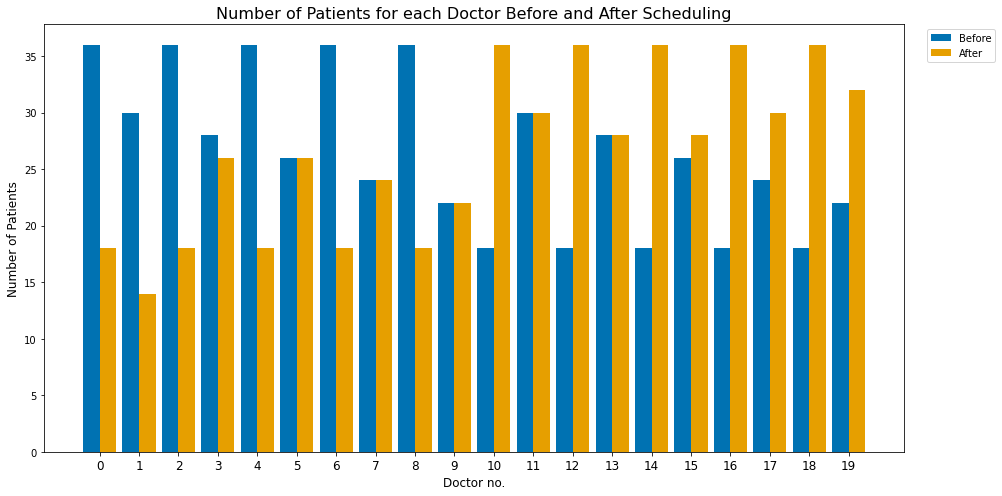

In [304]:
import matplotlib.pyplot as plt

bar_width = 0.42

# Define the colors of the bars
dpat_before_color = '#0072B2'
dpat_after_color = '#E69F00'

# Create the figure and plot the data
fig = plt.figure(figsize=(14, 7))
plt.bar(np.arange(td), df['no. Patients Before Sched'], width=bar_width, color=dpat_before_color)
plt.bar(np.arange(td) + bar_width, df['no. Patients After Sched'], width=bar_width, color=dpat_after_color)

# Set the x-ticks
plt.xticks(np.arange(td) + bar_width/2, np.arange(td), fontsize=12)

# Add labels and a legend
plt.xlabel('Doctor no.', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.title('Number of Patients for each Doctor Before and After Scheduling', fontsize=16)

# Move the legend closer to the frame
plt.legend(['Before', 'After'], bbox_to_anchor=(1.02, 1), loc='upper left')

# Adjust the plot's tight layout
plt.tight_layout()

# Show the plot
plt.show()

# Second Formulation alternative.

In [305]:
m = Model(name='Lean_Scheduling')

In [306]:
npp=m.integer_var_list(td, -tp, tp, name='number of patients transferred for doctor %s')
npp

[docplex.mp.Var(type=I,name='number of patients transferred for doctor 0',lb=-530,ub=530),
 docplex.mp.Var(type=I,name='number of patients transferred for doctor 1',lb=-530,ub=530),
 docplex.mp.Var(type=I,name='number of patients transferred for doctor 2',lb=-530,ub=530),
 docplex.mp.Var(type=I,name='number of patients transferred for doctor 3',lb=-530,ub=530),
 docplex.mp.Var(type=I,name='number of patients transferred for doctor 4',lb=-530,ub=530),
 docplex.mp.Var(type=I,name='number of patients transferred for doctor 5',lb=-530,ub=530),
 docplex.mp.Var(type=I,name='number of patients transferred for doctor 6',lb=-530,ub=530),
 docplex.mp.Var(type=I,name='number of patients transferred for doctor 7',lb=-530,ub=530),
 docplex.mp.Var(type=I,name='number of patients transferred for doctor 8',lb=-530,ub=530),
 docplex.mp.Var(type=I,name='number of patients transferred for doctor 9',lb=-530,ub=530),
 docplex.mp.Var(type=I,name='number of patients transferred for doctor 10',lb=-530,ub=530)

In [307]:
LWT=m.integer_var(0, None, name='max working time after scheduling')
LWT

docplex.mp.Var(type=I,name='max working time after scheduling')

In [308]:
#Constraint 1
m.add_constraints([(et+dt)*dpat[i] + et*npp[i] <= work_time[i] for i in range(0,td)])

[docplex.mp.LinearConstraint[](5number of patients transferred for doctor 0+360,LE,360),
 docplex.mp.LinearConstraint[](5number of patients transferred for doctor 1+300,LE,360),
 docplex.mp.LinearConstraint[](5number of patients transferred for doctor 2+360,LE,360),
 docplex.mp.LinearConstraint[](5number of patients transferred for doctor 3+280,LE,360),
 docplex.mp.LinearConstraint[](5number of patients transferred for doctor 4+360,LE,360),
 docplex.mp.LinearConstraint[](5number of patients transferred for doctor 5+260,LE,360),
 docplex.mp.LinearConstraint[](5number of patients transferred for doctor 6+360,LE,360),
 docplex.mp.LinearConstraint[](5number of patients transferred for doctor 7+240,LE,360),
 docplex.mp.LinearConstraint[](5number of patients transferred for doctor 8+360,LE,360),
 docplex.mp.LinearConstraint[](5number of patients transferred for doctor 9+220,LE,360),
 docplex.mp.LinearConstraint[](5number of patients transferred for doctor 10+180,LE,360),
 docplex.mp.LinearCo

In [309]:
#Constraints 2 & 3 merged
m.add_constraints([(et+dt)*dpat[i] + et*npp[i] <= LWT for i in range(0,td)])

[docplex.mp.LinearConstraint[](5number of patients transferred for doctor 0+360,LE,max working time after scheduling),
 docplex.mp.LinearConstraint[](5number of patients transferred for doctor 1+300,LE,max working time after scheduling),
 docplex.mp.LinearConstraint[](5number of patients transferred for doctor 2+360,LE,max working time after scheduling),
 docplex.mp.LinearConstraint[](5number of patients transferred for doctor 3+280,LE,max working time after scheduling),
 docplex.mp.LinearConstraint[](5number of patients transferred for doctor 4+360,LE,max working time after scheduling),
 docplex.mp.LinearConstraint[](5number of patients transferred for doctor 5+260,LE,max working time after scheduling),
 docplex.mp.LinearConstraint[](5number of patients transferred for doctor 6+360,LE,max working time after scheduling),
 docplex.mp.LinearConstraint[](5number of patients transferred for doctor 7+240,LE,max working time after scheduling),
 docplex.mp.LinearConstraint[](5number of patien

In [310]:
#npp constraint for overbooked sr doctors 
for i in range(tds):
    if dpat[i] > tp/td:
        m.add_constraint(npp[i] <= 0)

In [311]:
#npp constraint for underbooked sr doctors 
for i in range(tds):
    if dpat[i] <= tp/td:
        m.add_constraint(npp[i] >= 0)

In [312]:
#**** In the paper, the formulation does not match the written text
#npp constraint for overbooked associate sr doctors 
for i in range(tds, td):
    if dpat[i] > tp/td:
        m.add_constraint(npp[i] <= 0)

In [313]:
#npp constraint for underbooked associate sr doctors 
for i in range(tds, td):
    if dpat[i] <= tp/td:
        m.add_constraint(npp[i] >= 0)

In [314]:
m.add_constraint(sum(npp[i] for i in range(0,td))==0)

docplex.mp.LinearConstraint[](number of patients transferred for doctor 0+number of patients transferred for doctor 1+number of patients transferred for doctor 2+number of patients transferred for doctor 3+number of patients transferred for doctor 4+number of patients transferred for doctor 5+number of patients transferred for doctor 6+number of patients transferred for doctor 7+number of patients transferred for doctor 8+number of patients transferred for doctor 9+number of patients transferred for doctor 10+number of patients transferred for doctor 11+number of patients transferred for doctor 12+number of patients transferred for doctor 13+number of patients transferred for doctor 14+number of patients transferred for doctor 15+number of patients transferred for doctor 16+number of patients transferred for doctor 17+number of patients transferred for doctor 18+number of patients transferred for doctor 19,EQ,0)

In [315]:
#objective is to minimize the Dr max working time
m.minimize(LWT)


In [316]:
m.export_as_lp('Lean_Scheduling.lp')

'Lean_Scheduling.lp'

In [317]:
m.print_information()
m.solve()
print(m.solve_status)
m.print_solution()
#Time is given in minutes

Model: Lean_Scheduling
 - number of variables: 21
   - binary=0, integer=21, continuous=0
 - number of constraints: 61
   - linear=61
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
JobSolveStatus.OPTIMAL_SOLUTION
objective: 265
  "number of patients transferred for doctor 0"=-19
  "number of patients transferred for doctor 1"=-7
  "number of patients transferred for doctor 2"=-19
  "number of patients transferred for doctor 3"=-3
  "number of patients transferred for doctor 4"=-19
  "number of patients transferred for doctor 5"=1
  "number of patients transferred for doctor 6"=-19
  "number of patients transferred for doctor 7"=5
  "number of patients transferred for doctor 8"=-19
  "number of patients transferred for doctor 9"=9
  "number of patients transferred for doctor 10"=17
  "number of patients transferred for doctor 11"=-7
  "number of patients transferred for doctor 12"=17
  "number of patients transferred for doctor 13"=-3
  "number of patients trans

In [318]:
print("Before Scheduling: ", np.max(work_time))
print("After Scheduling: ", int(round(LWT.solution_value, 0)))

Before Scheduling:  360
After Scheduling:  265


In [319]:
import pandas as pd
import numpy as np
x=[npp[i].solution_value for i in range(td)]
dpat_sched=np.array(dpat)+np.array(x)
[npp[i].solution_value for i in range(td)]
df1=pd.DataFrame({"no. Patients Before Sched": dpat, "no. Patients After Sched": dpat_sched, "Difference": x})
df1

,no. Patients Before Sched,no. Patients After Sched,Difference
0,36,17.0,-19.0
1,30,23.0,-7.0
2,36,17.0,-19.0
3,28,25.0,-3.0
4,36,17.0,-19.0
5,26,27.0,1.0
6,36,17.0,-19.0
7,24,29.0,5.0
8,36,17.0,-19.0
9,22,31.0,9.0


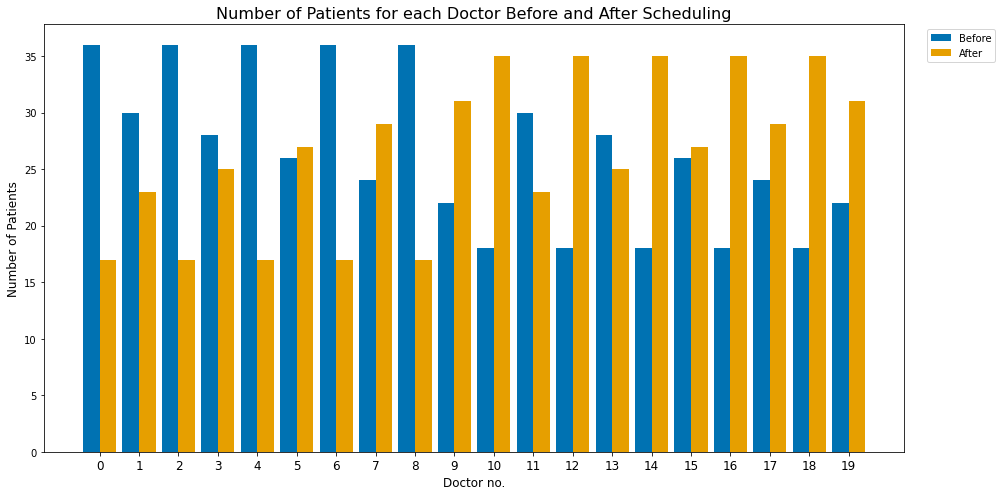

In [320]:
import matplotlib.pyplot as plt

bar_width = 0.42

# Define the colors of the bars
dpat_before_color = '#0072B2'
dpat_after_color = '#E69F00'

# Create the figure and plot the data
fig = plt.figure(figsize=(14, 7))
plt.bar(np.arange(td), df1['no. Patients Before Sched'], width=bar_width, color=dpat_before_color)
plt.bar(np.arange(td) + bar_width, df1['no. Patients After Sched'], width=bar_width, color=dpat_after_color)

# Set the x-ticks
plt.xticks(np.arange(td) + bar_width/2, np.arange(td), fontsize=12)

# Add labels and a legend
plt.xlabel('Doctor no.', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.title('Number of Patients for each Doctor Before and After Scheduling', fontsize=16)

# Move the legend closer to the frame
plt.legend(['Before', 'After'], bbox_to_anchor=(1.02, 1), loc='upper left')

# Adjust the plot's tight layout
plt.tight_layout()

# Show the plot
plt.show()

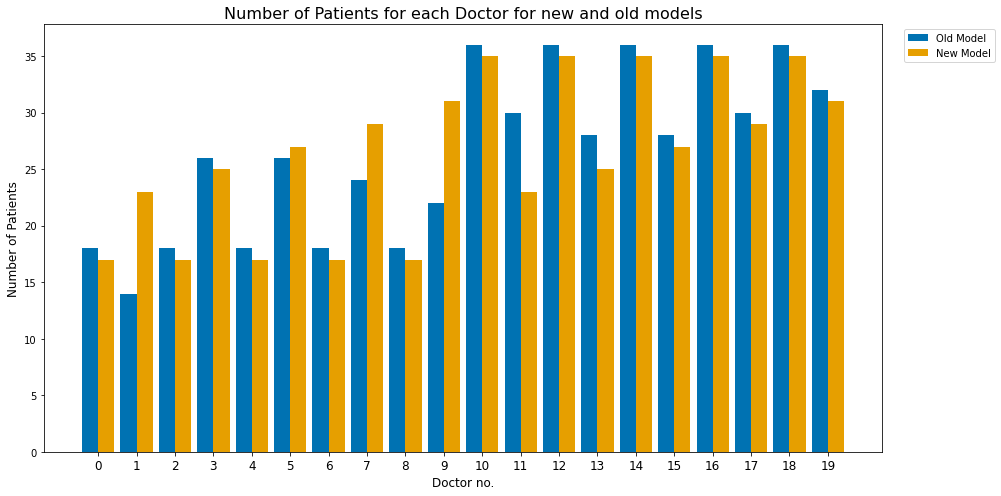

In [321]:
import matplotlib.pyplot as plt

bar_width = 0.42

# Define the colors of the bars
dpat_before_color = '#0072B2'
dpat_after_color = '#E69F00'

# Create the figure and plot the data
fig = plt.figure(figsize=(14, 7))
plt.bar(np.arange(td), df['no. Patients After Sched'], width=bar_width, color=dpat_before_color)
plt.bar(np.arange(td) + bar_width, df1['no. Patients After Sched'], width=bar_width, color=dpat_after_color)

# Set the x-ticks
plt.xticks(np.arange(td) + bar_width/2, np.arange(td), fontsize=12)

# Add labels and a legend
plt.xlabel('Doctor no.', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.title('Number of Patients for each Doctor for new and old models', fontsize=16)

# Move the legend closer to the frame
plt.legend(['Old Model', 'New Model'], bbox_to_anchor=(1.02, 1), loc='upper left')

# Adjust the plot's tight layout
plt.tight_layout()

# Show the plot
plt.show()